# Task 1: EDA

In [29]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For regression models and evaluation later
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
df = pd.read_csv("hour.csv")  # Make sure hour.csv is in the same directory or provide full path

# Display first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Basic info
print("\nDataset Info:")
print(df.info())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

First 5 rows of the dataset:
   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379

We removed the following columns from the dataset:

- Instant: it is just a unique id for each row, doesnt add any predictive value

- dteday: A string version of the date. Since we already have features like year (yr), month (mnth), and day of the week (weekday), this becomes redundant.

- casual and registered: These two columns together directly sum up to the target variable (cnt), which represents the total bike rentals. Keeping them would be a form of data leakage because the model would learn the target from its components instead of actual predictors.


In [30]:
df.drop(columns=['instant', 'dteday', 'casual', 'registered'], inplace=True)

### EDA Visualizations

<Figure size 1200x600 with 0 Axes>

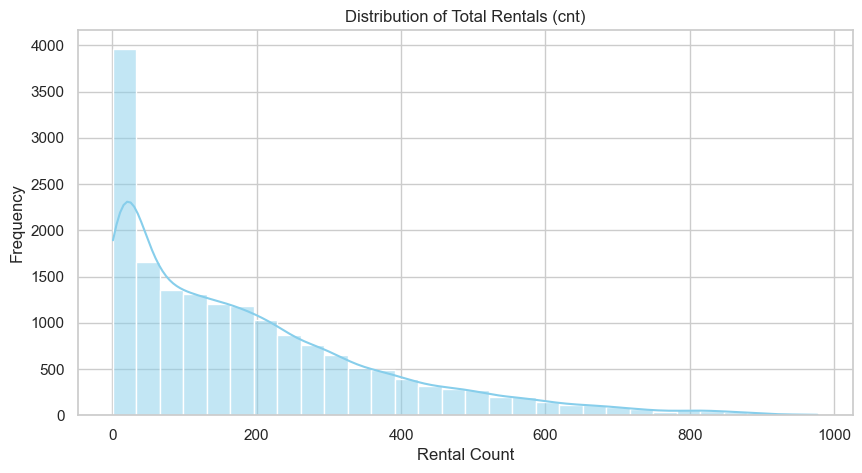

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# 1. Distribution of Total Rentals (cnt)
plt.figure(figsize=(10, 5))
sns.histplot(df['cnt'], kde=True, bins=30, color="skyblue")
plt.title("Distribution of Total Rentals (cnt)")
plt.xlabel("Rental Count")
plt.ylabel("Frequency")
plt.show()

Helps us understand how bike rentals are distributed. The histogram shows that most bike rental sessions fall on the lower end of the scale, with a noticeable right skew. This makes sense because high rental spikes are rarer, while lower or moderate rental volumes are more common. The peak is strong in the 0-100 rental range and then it gradually decreases. High rental counts are much more rare, which is somethign that we were expecting.


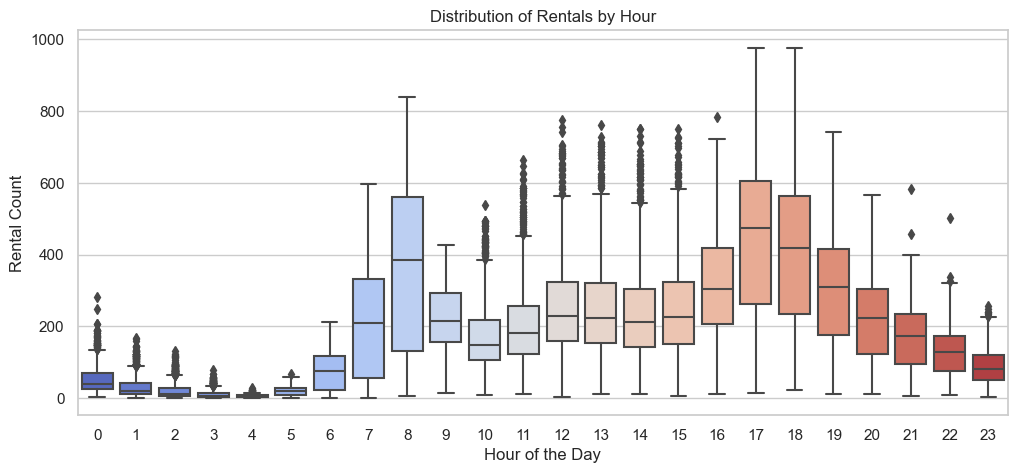

In [3]:
# 2. Rentals by Hour of the Day
plt.figure(figsize=(12, 5))
sns.boxplot(x='hr', y='cnt', data=df, palette="coolwarm")
plt.title("Distribution of Rentals by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Rental Count")
plt.show()

Shows usage trends by hour. We can see that there are 2 noticeable peaks which are morning hours around 8AM and afternoon around 5-6PM. This makes sense as they are likely the typical commuting hours. We can also see that early in the morning there are far few less people who rent bikes (2-5AM)

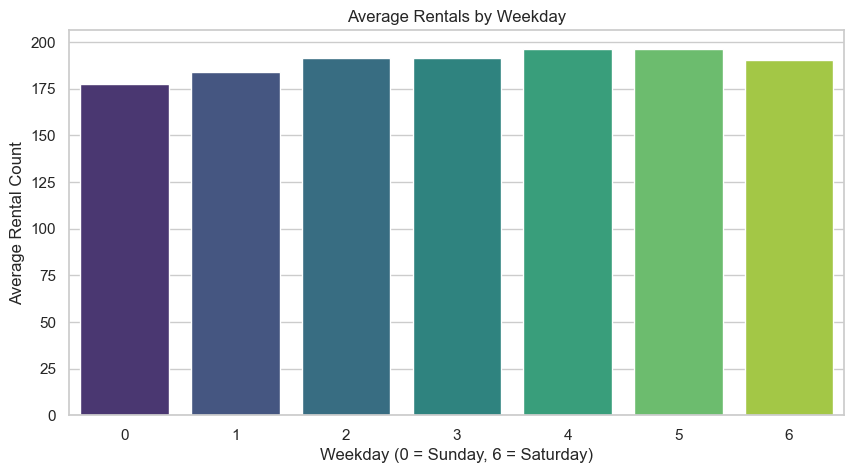

In [4]:
# 3. Average Rentals by Weekday
plt.figure(figsize=(10, 5))
weekday_avg = df.groupby("weekday")["cnt"].mean().reset_index()
sns.barplot(x="weekday", y="cnt", data=weekday_avg, palette="viridis")
plt.title("Average Rentals by Weekday")
plt.xlabel("Weekday (0 = Sunday, 6 = Saturday)")
plt.ylabel("Average Rental Count")
plt.show()

Helps spot trends across weekdays. We can see that the rentals stay pretty consistent during weekends as well as weekdays. There are more rentals on Thursdays-Fridays, but in general it stays pretty consistent. Although Sunday is the day with the least rentals, its not highly significant. We can assume then that they use bikes for commuting as well as for leisure.

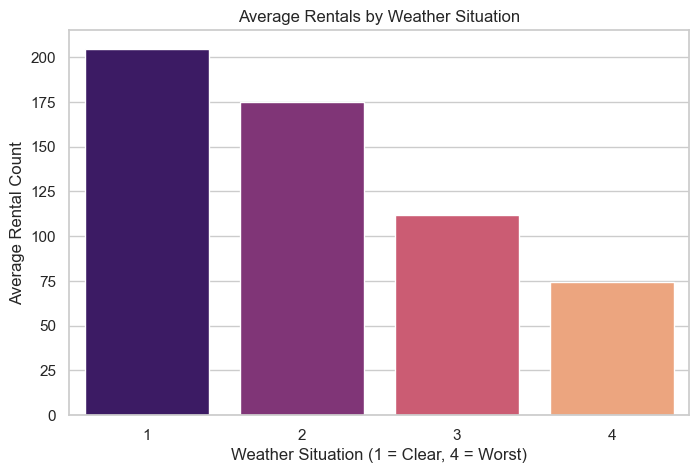

In [5]:
# 4. Rentals by Weather Situation
plt.figure(figsize=(8, 5))
weather_avg = df.groupby("weathersit")["cnt"].mean().reset_index()
sns.barplot(x="weathersit", y="cnt", data=weather_avg, palette="magma")
plt.title("Average Rentals by Weather Situation")
plt.xlabel("Weather Situation (1 = Clear, 4 = Worst)")
plt.ylabel("Average Rental Count")
plt.show()

Explores how external weather conditions affect bike usage. As we would expect in our data there is a negative correlation between poor weather and bike rental. The highest rental count occurs when the weathcer is clear and it drops as the weather also drops.

# Task 2: Data Splitting

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Separate target and features
X = df.drop(columns=['cnt'])  # 'cnt' is the target variable
y = df['cnt']

# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=13)

# Second split: 20% val, 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=13)

# Show the result
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (10427, 12)
Validation set shape: (3476, 12)
Test set shape: (3476, 12)


I split the data into 3 sets: 60% for training, 20% for validation, and 20% for testing. I did this by using train_test_split, ensuring that the model has enough data to learn from patters, enough separate data to tune parameters, and untouched data in order to evaluate performance.

We are doing this before of feature engineering in order to avoid data leakage. We don't want any over optimistic performance and poor generalization.


# Task 3: Feature Engineering

We have to encode cyclical features because there is a circular nature. hour 0 and hour 23 are right next to each other, not that far away. The same thing happens with weekdays, monday and sunday are right next to each other. We used sine and cosine in order to capture patterns that repeat cyclically so now it will be between -1 and 1.

In [37]:
# Save original hr and weekday for visualization
print("Previewing original 'hr' and 'weekday' before encoding:")
print(X_train[['hr', 'weekday']].head() if 'hr' in X_train.columns and 'weekday' in X_train.columns else "Already dropped!")

# === Cyclical Encoding Function ===
def encode_cyclical_feature(df, column, max_val):
    df[column + '_sin'] = np.sin(2 * np.pi * df[column] / max_val)
    df[column + '_cos'] = np.cos(2 * np.pi * df[column] / max_val)
    return df

# Only apply encoding if columns still exist
for cyclical_col, max_val in [('hr', 24), ('weekday', 7)]:
    if cyclical_col in X_train.columns:
        X_train = encode_cyclical_feature(X_train, cyclical_col, max_val)
        X_val = encode_cyclical_feature(X_val, cyclical_col, max_val)
        X_test = encode_cyclical_feature(X_test, cyclical_col, max_val)

# Show encoded columns
print("\nAfter cyclical encoding:")
cyclic_cols = ['hr_sin', 'hr_cos', 'weekday_sin', 'weekday_cos']
available_cyclic = [col for col in cyclic_cols if col in X_train.columns]
print(X_train[available_cyclic].head())

# Drop original cols if not already dropped
for col in ['hr', 'weekday']:
    for dataset in [X_train, X_val, X_test]:
        if col in dataset.columns:
            dataset.drop(columns=[col], inplace=True)

Previewing original 'hr' and 'weekday' before encoding:
Already dropped!

After cyclical encoding:
         hr_sin    hr_cos  weekday_sin  weekday_cos
14779  0.000000  1.000000    -0.433884    -0.900969
16914 -0.258819 -0.965926     0.433884    -0.900969
15863  0.866025  0.500000     0.000000     1.000000
4204   0.500000  0.866025     0.433884    -0.900969
1554   0.965926  0.258819    -0.433884    -0.900969


I also applied one-hot econding to season, weathersit, and month. This will convert them into binary variables, this is done because these variables are cateogrical.  We dont want the labels to be seen as magnitudes. 

In [39]:
X_train_original = X_train.copy()
# Preview unique values before encoding
print("Before One-Hot Encoding:")
print("Season unique values:", X_train_original['season'].unique())
print("Weathersit unique values:", X_train_original['weathersit'].unique())
print("Month unique values:", X_train_original['mnth'].unique())

# One-hot encoding
categorical_cols = ['season', 'weathersit', 'mnth']
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_val = pd.get_dummies(X_val, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Re-align columns to ensure consistent shapes
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Check encoded columns
print("\nAfter One-Hot Encoding (sample of columns):")
encoded_cols = [col for col in X_train.columns if any(cat in col for cat in ['season_', 'weathersit_', 'mnth_'])]
print(X_train[encoded_cols].head())

Before One-Hot Encoding:
Season unique values: [3 4 1 2]
Weathersit unique values: [1 2 3 4]
Month unique values: [ 9 12 10  6  3  2  5 11  1  7  8  4]

After One-Hot Encoding (sample of columns):
       season_2  season_3  season_4  weathersit_2  weathersit_3  weathersit_4  \
14779     False      True     False         False         False         False   
16914     False     False      True          True         False         False   
15863     False     False      True          True         False         False   
4204      False      True     False         False         False         False   
1554      False     False     False         False          True         False   

       mnth_2  mnth_3  mnth_4  mnth_5  mnth_6  mnth_7  mnth_8  mnth_9  \
14779   False   False   False   False   False   False   False    True   
16914   False   False   False   False   False   False   False   False   
15863   False   False   False   False   False   False   False   False   
4204    False   False   

I did scaling because it ensures that features with different ranges are brought to a similar scale. So it makes everything fair as it is working on the same scale instead of giving more importance to variables which ranges are with bigger numbers.

In [40]:
# Store a copy of the original (before scaling)
X_train_before_scaling = X_train.copy()

# Apply scaling
scaler = StandardScaler()
cont_cols = ['temp', 'atemp', 'hum', 'windspeed']
X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
X_val[cont_cols] = scaler.transform(X_val[cont_cols])
X_test[cont_cols] = scaler.transform(X_test[cont_cols])

# Visualize the effect
print("Before Scaling:")
print(X_train_before_scaling[cont_cols].describe())

print("\nAfter Scaling:")
print(X_train[cont_cols].describe())


Before Scaling:
               temp         atemp           hum     windspeed
count  10427.000000  10427.000000  10427.000000  10427.000000
mean       0.496436      0.475479      0.626612      0.190609
std        0.193049      0.172721      0.192536      0.121860
min        0.020000      0.000000      0.000000      0.000000
25%        0.340000      0.333300      0.480000      0.104500
50%        0.500000      0.484800      0.620000      0.194000
75%        0.660000      0.621200      0.780000      0.253700
max        1.000000      1.000000      1.000000      0.850700

After Scaling:
               temp         atemp           hum     windspeed
count  1.042700e+04  1.042700e+04  1.042700e+04  1.042700e+04
mean  -1.454885e-16 -2.524754e-16 -4.054598e-16  1.011946e-16
std    1.000048e+00  1.000048e+00  1.000048e+00  1.000048e+00
min   -2.468067e+00 -2.753011e+00 -3.254674e+00 -1.564243e+00
25%   -8.103813e-01 -8.232137e-01 -7.615134e-01 -7.066588e-01
50%    1.846157e-02  5.396689e-02 -3.4

I added an interaction term between temp and humidity. This was motivated by the idea that hot + humid conditions might impact bike usage differently than hot + dry weather. Interaction terms help the model capture non-linear combined effects

In [41]:
X_train['temp_hum'] = X_train['temp'] * X_train['hum']
X_val['temp_hum'] = X_val['temp'] * X_val['hum']
X_test['temp_hum'] = X_test['temp'] * X_test['hum']

X_train['hr_workingday'] = X_train['hr_cos'] * X_train['workingday']  # using encoded hr
X_val['hr_workingday'] = X_val['hr_cos'] * X_val['workingday']
X_test['hr_workingday'] = X_test['hr_cos'] * X_test['workingday']

X_train['season_weathersit'] = X_train['season_2'] * X_train['weathersit_2'] if 'season_2' in X_train and 'weathersit_2' in X_train else 0
X_val['season_weathersit'] = X_val['season_2'] * X_val['weathersit_2'] if 'season_2' in X_val and 'weathersit_2' in X_val else 0
X_test['season_weathersit'] = X_test['season_2'] * X_test['weathersit_2'] if 'season_2' in X_test and 'weathersit_2' in X_test else 0

print("\nSample interaction terms:")
print(X_train[['temp_hum', 'hr_workingday', 'season_weathersit']].head())


Sample interaction terms:
       temp_hum  hr_workingday  season_weathersit
14779  0.176825       1.000000              False
16914  0.869668      -0.965926              False
15863  0.000325       0.000000              False
4204   0.895106       0.866025              False
1554   2.300325       0.258819              False


After reviewing the correlation matrix, I found that atemp (feels-like temperature) is highly correlated with temp. Including both might introduce multicollinearity. So I dropped atemp to reduce redundancy and make the model more interpretable.

In [26]:
X_train.drop(columns=['atemp'], inplace=True)
X_val.drop(columns=['atemp'], inplace=True)
X_test.drop(columns=['atemp'], inplace=True)

# Task 4: Baseline Model - Linear Regression

Lets first reload the original dataset and split it, then we can start training a simple linear regression without the encoding and evaluate how it works.

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Reload the raw dataset
df_baseline = pd.read_csv("hour.csv")

# Step 2: Drop leaky and non-predictive columns
df_baseline.drop(columns=['instant', 'dteday', 'casual', 'registered'], inplace=True)

# Step 3: Define features and target
X = df_baseline.drop(columns=['cnt'])  # Features
y = df_baseline['cnt']                 # Target

# Step 4: Split into train, validation, test
X_train_b, X_temp_b, y_train_b, y_temp_b = train_test_split(X, y, test_size=0.2, random_state=42)
X_val_b, X_test_b, y_val_b, y_test_b = train_test_split(X_temp_b, y_temp_b, test_size=0.5, random_state=42)

In [46]:
# Step 5: Train baseline Linear Regression
baseline_model = LinearRegression()
baseline_model.fit(X_train_b, y_train_b)

# Predict on validation set
y_val_pred_b = baseline_model.predict(X_val_b)

# Step 6: Evaluation Metrics
mse = mean_squared_error(y_val_b, y_val_pred_b)
mae = mean_absolute_error(y_val_b, y_val_pred_b)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_b, y_val_pred_b)

print("Baseline Model Evaluation on Validation Set:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


Baseline Model Evaluation on Validation Set:
Mean Squared Error (MSE): 20150.19
Mean Absolute Error (MAE): 106.13
Root Mean Squared Error (RMSE): 141.95
R² Score: 0.3991


We can see that the model's prediction on the baseline are off by 142 rentals which is a lot. We can also see by the MAE that on average predictions are off by 106, regardless of the direction of the error. The MSE is 20,150 which means that the model is making significant prediciton mistakes. 
The model also explains roughly 40% of the variance in bike rentals meaning that there is a lot of the data's behavior that it doesnt capture in the model.

#### Plot - Actual vs Predicted

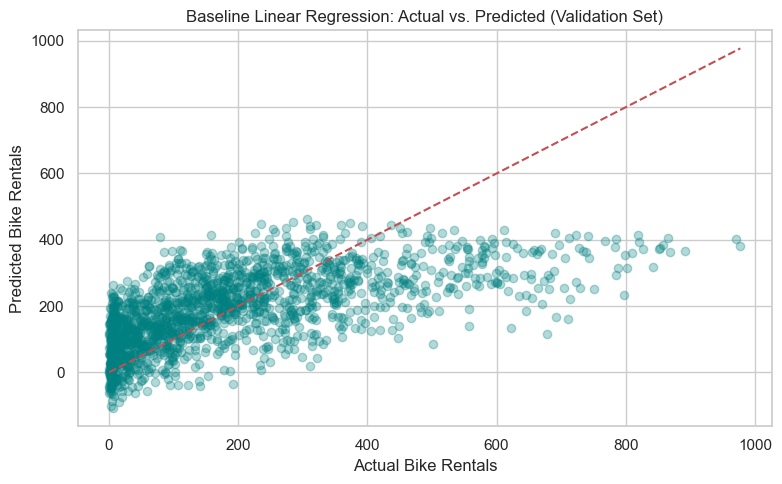

In [50]:
# Step 7: Plot actual vs. predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_val_b, y_val_pred_b, alpha=0.3, color='teal')
plt.plot([y_val_b.min(), y_val_b.max()], [y_val_b.min(), y_val_b.max()], 'r--')
plt.xlabel("Actual Bike Rentals")
plt.ylabel("Predicted Bike Rentals")
plt.title("Baseline Linear Regression: Actual vs. Predicted (Validation Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

The model is underestimating high rental counts as we can see by the points falling under the dotted line. 

#### Plot - Residual Distribution

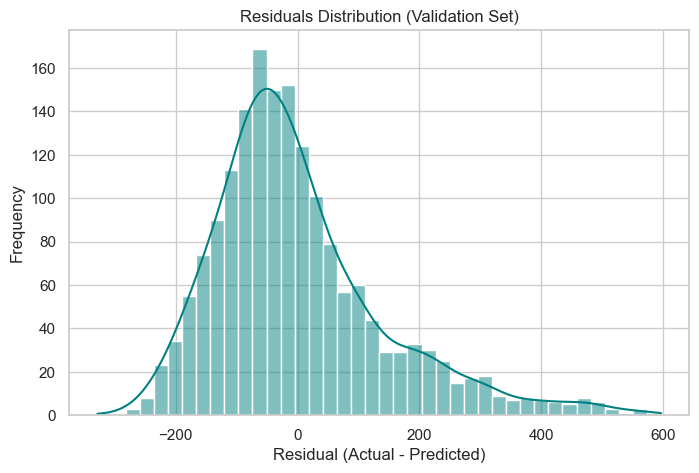

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute residuals
residuals = y_val_b - y_val_pred_b

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=40, color='teal')
plt.title("Residuals Distribution (Validation Set)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

We can see that the residuals are centered around 0, which is a good sign because it menans that its not significantly overpredicting or underpredicting. It is clearly skewed to the right though, which means that it underestimates the bike rentals on the higher end.

We would ideally like it to be more tihghtly concentrated around 0. This just means that the model is struggling with complex scenarios, so might be a bit biased right now. 

#### Plot - Residuals vs Predicted 

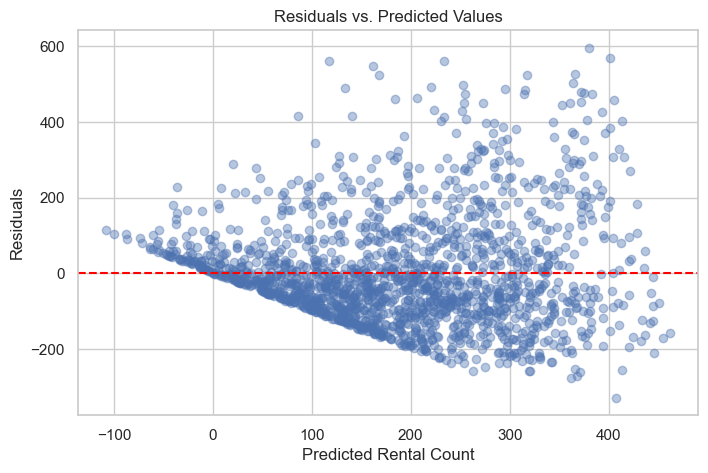

In [49]:
# Residuals vs. predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_val_pred_b, residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Rental Count")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

We can see that the model performs worse whenever there's a higher number of rentals. We can see heteroscedasticity, which means that its errors are not consistent at all levels of prediction.

We can see that predictions for smaller rentals counts tend to be more accurate but as there are more rental counts there are more residuals meaning that there are underpredicting them. 


This is a good reference point, so now we can start adding the feature engineering and see how much is our model going to improve. 